In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# pip install yfinance --upgrade --no-cache-dir

In [3]:
pip install --upgrade yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.50
    Uninstalling yfinance-0.2.50:
      Successfully uninstalled yfinance-0.2.50
Note: you may need to restart the kernel to use updated packages.


In [4]:
import yfinance as yf
import matplotlib.pyplot as plt

df = yf.download("SPY", start="2024-01-01", end="2025-03-03")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
df['Ret'] = df['Close'].pct_change()
df['Ret10_i'] = df['Ret'].rolling(10).apply(lambda x: 100 * ((np.prod(1+x))**(1/10)-1)) 
df['Ret20_i'] = df['Ret'].rolling(20).apply(lambda x: 100 * ((np.prod(1+x))**(1/20)-1)) 
df['Ret30_i'] = df['Ret'].rolling(30).apply(lambda x: 100 * ((np.prod(1+x))**(1/30)-1)) 
df['Ret40_i'] = df['Ret'].rolling(40).apply(lambda x: 100 * ((np.prod(1+x))**(1/40)-1)) 
df['Ret50_i'] = df['Ret'].rolling(50).apply(lambda x: 100 * ((np.prod(1+x))**(1/50)-1)) 

In [6]:
del df["Open"]
del df["Close"]
del df["High"]
del df["Low"]
del df["Volume"]

df = df.dropna()
df.tail(10)

Price,Ret,Ret10_i,Ret20_i,Ret30_i,Ret40_i,Ret50_i
Ticker,,,,,,
Date,,,,,,
2025-02-14,-0.000049,0.130171,0.150457,0.131789,0.020363,0.026735
2025-02-18,0.002936,0.227183,0.115118,0.149786,0.038018,0.031672
2025-02-19,0.002355,0.183756,0.081286,0.116163,0.119605,0.023993
2025-02-20,-0.004160,0.101485,0.032385,0.083086,0.109939,0.018948
2025-02-21,-0.017104,-0.105727,-0.081064,0.063460,0.036906,-0.019343
2025-02-24,-0.004550,-0.059416,-0.089243,0.043380,0.010572,-0.018139
2025-02-25,-0.004973,-0.176815,-0.042970,0.078066,-0.029522,-0.021882
2025-02-26,0.000505,-0.179367,-0.083200,0.074582,-0.028427,-0.036270


In [7]:
df['Ret20'] = df['Ret20_i'].shift(-20)
df= df.dropna()

In [8]:
X = df.iloc[:,0:-1]
y = df.iloc[:,-1]
print(X.shape, y.shape)

(221, 6) (221,)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=int(len(y) * 0.2), shuffle=False)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(177, 6) (44, 6) (177,) (44,)


## Ridge

In [10]:
from sklearn.linear_model import Ridge

ridgeR = Ridge(alpha=0.7)
ridgeR.fit(X_train, y_train)
y_pred_ridge = ridgeR.predict(X_train)
y_pred_test_ridge = ridgeR.predict(X_test)

In [11]:
mean_squared_error = np.mean((y_pred_test_ridge - y_test)**2)
print('Mean Squared Error on the test set', mean_squared_error)

Mean Squared Error on the test set 0.019011604980492987


In [12]:
ridge_coef = pd.DataFrame({"Columns": list(X_train.columns)})
ridge_coef['Coef Extimate'] =  pd.Series(ridgeR.coef_)
ridge_coef

,Columns,Coef Extimate
0,"(Ret, )",-0.010517
1,"(Ret10_i, )",-0.057506
2,"(Ret20_i, )",-0.085374
3,"(Ret30_i, )",-0.082562
4,"(Ret40_i, )",-0.309163
5,"(Ret50_i, )",-0.625971


## Lasso

In [13]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.0001)
lasso.fit(X_train, y_train)
y_pred_Lasso = lasso.predict(X_train)
y_pred_test_lasso = lasso.predict(X_test)

mean_squared_error = np.mean((y_pred_test_lasso - y_test) ** 2)
print("Mean squared error on test set", mean_squared_error)

Mean squared error on test set 0.022356451696282656


In [14]:
lasso_coef = pd.DataFrame({'Columns':X_train.columns})
lasso_coef['Coef Estimate'] = pd.Series(lasso.coef_)

lasso_coef

,Columns,Coef Estimate
0,"(Ret, )",-0.000000
1,"(Ret10_i, )",-0.031821
2,"(Ret20_i, )",-0.036041
3,"(Ret30_i, )",0.067504
4,"(Ret40_i, )",-0.185908
5,"(Ret50_i, )",-1.525048


## Elastic Net

In [15]:
from sklearn.linear_model import ElasticNet

e_net = ElasticNet(alpha=0.0001, l1_ratio=0.2)
e_net.fit(X_train, y_train)
y_pred_elastic = e_net.predict(X_test)
mean_squared_error = np.mean((y_pred_elastic - y_test) ** 2)
print("Mean Squared Error on test set", mean_squared_error)

Mean Squared Error on test set 0.022312883988062006


In [16]:
e_net_coeff = pd.DataFrame({"Columns": list(X_train.columns)})
e_net_coeff["Coefficient Estimate"] = pd.Series(e_net.coef_)
e_net_coeff

,Columns,Coefficient Estimate
0,"(Ret, )",-0.192553
1,"(Ret10_i, )",-0.031341
2,"(Ret20_i, )",-0.046892
3,"(Ret30_i, )",0.097277
4,"(Ret40_i, )",-0.228517
5,"(Ret50_i, )",-1.493611


## Hyperparameter Tuning

In [17]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold

model = ElasticNet()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = [0, 0.01, 0.1, 0.2, 0.5, 0.7, 1]
search = GridSearchCV(model, grid, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)

In [18]:
results = search.fit(X_train, y_train)
print("MSE: %.3f" % results.best_score_)
print("Config: %s" % results.best_params_)

MSE: -0.007
Config: {'alpha': 0.0001, 'l1_ratio': 0}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.369e-01, tolerance: 3.458e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [19]:
e_net = ElasticNet(alpha=0.0001, l1_ratio=0)
e_net.fit(X_train, y_train)
y_pred_elastic = e_net.predict(X_test)
mean_squared_error = np.mean((y_pred_elastic - y_test) ** 2)
print("Mean Squared Error on test set", mean_squared_error)

Mean Squared Error on test set 0.02232802382595446


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.369e-01, tolerance: 3.458e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


## Classification

In [20]:
df['Output'] = df['Ret20'].apply(np.sign)
del df['Ret20']
df.tail(10)

Price,Ret,Ret10_i,Ret20_i,Ret30_i,Ret40_i,Ret50_i,Output
Ticker,,,,,,,
Date,,,,,,,
2025-01-16,-0.001923,0.094465,-0.109562,-0.055661,0.033419,0.077628,1.0
2025-01-17,0.010040,0.219159,-0.039022,-0.023920,0.048177,0.101942,1.0
2025-01-21,0.009154,0.185952,0.157938,-0.014183,0.061842,0.096122,1.0
2025-01-22,0.005621,0.184566,0.187553,0.009992,0.075019,0.058181,1.0
2025-01-23,0.005458,0.353134,0.155016,0.021825,0.075242,0.053660,-1.0
2025-01-24,-0.002919,0.309154,0.110487,0.029291,0.060186,0.039162,-1.0
2025-01-27,-0.014145,0.320578,-0.016073,-0.007821,0.016088,0.008757,-1.0
2025-01-28,0.008592,0.390892,0.026375,-0.004972,0.024459,0.032095,-1.0


In [21]:
df.describe()

Price,Ret,Ret10_i,Ret20_i,Ret30_i,Ret40_i,Ret50_i,Output
Ticker,,,,,,,
count,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000
mean,0.000812,0.079832,0.077881,0.081653,0.087557,0.091575,0.484163
std,0.008135,0.243010,0.137907,0.097563,0.074353,0.061443,0.876964
min,-0.029803,-0.693184,-0.394433,-0.170217,-0.074054,-0.041107,-1.000000
25%,-0.002879,-0.059888,0.009911,-0.000990,0.034746,0.042084,-1.000000
50%,0.001152,0.110756,0.110487,0.097066,0.089694,0.081773,1.000000
75%,0.005762,0.239252,0.166241,0.160171,0.142611,0.132235,1.000000
max,0.024866,0.787710,0.335351,0.320866,0.249688,0.238054,1.000000


In [22]:
X = df.iloc[:,0:-1]
y = df.iloc[:, -1]
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=int(len(y)*0.2), shuffle = False)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(177, 6) (177,) (44, 6) (44,)


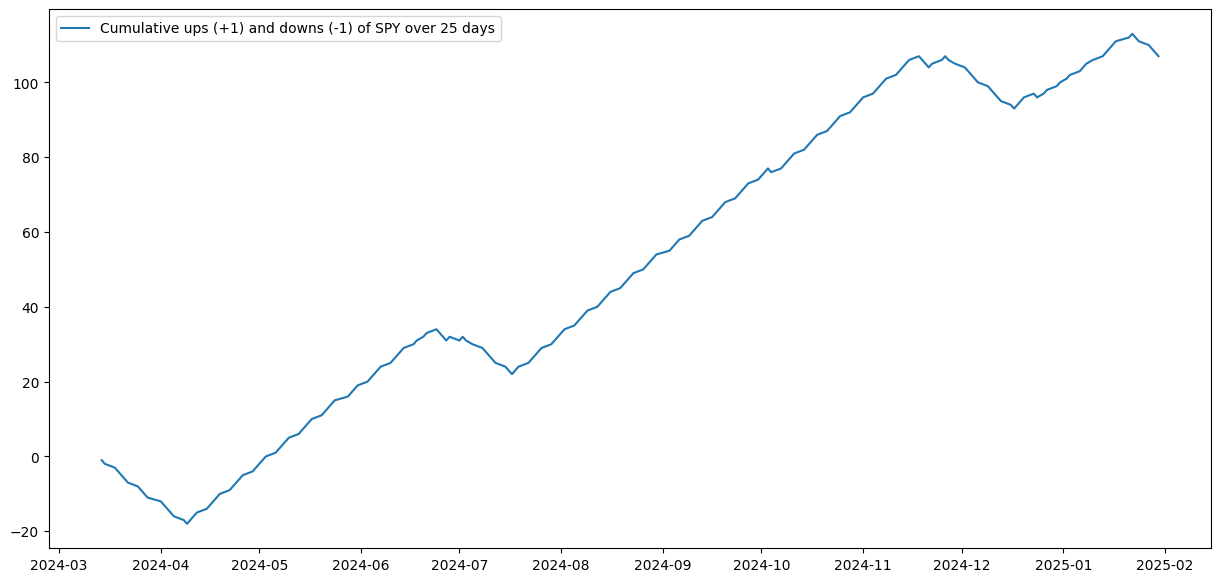

In [23]:
plt.figure(figsize=(15, 7))
plt.plot(df.index,np.cumsum(y),label="Cumulative ups (+1) and downs (-1) of SPY over 25 days",)
legend = plt.legend(loc="upper left")
plt.show()

## Standarization

In [24]:
X_train.head()

Price,Ret,Ret10_i,Ret20_i,Ret30_i,Ret40_i,Ret50_i
Ticker,,,,,,
Date,,,,,,
2024-03-14,-0.001977,0.134399,0.161760,0.214568,0.216425,0.171576
2024-03-15,-0.006867,-0.028034,0.092840,0.148137,0.176989,0.174201
2024-03-18,0.005943,0.041955,0.147496,0.132959,0.160802,0.192538
2024-03-19,0.005557,0.198005,0.202905,0.163637,0.169391,0.200900
2024-03-20,0.009249,0.239621,0.244505,0.184699,0.185155,0.190945


In [25]:
store = []
for i in range (len(X_train.columns)):
    min_value = X_train.iloc[:,i].min()
    max_value = X_train.iloc[:,i].max()
    normalized_col = []
    for j in range (len(X_train)):
        x_j = (X_train.iloc[j,i] - min_value)/(max_value - min_value)
        normalized_col.append(x_j)
    store.append(normalized_col)

In [26]:
X_train_scaled = pd.DataFrame(np.array(store).T, columns = X_train.columns)
X_train_scaled.head()

Price,Ret,Ret10_i,Ret20_i,Ret30_i,Ret40_i,Ret50_i
Ticker,,,,,,
0,0.502818,0.558840,0.762134,0.783545,0.897256,0.761866
1,0.412250,0.449154,0.667696,0.648269,0.775441,0.771267
2,0.649513,0.496416,0.742589,0.617363,0.725443,0.836954
3,0.642365,0.601791,0.818514,0.679832,0.751971,0.866910
4,0.710754,0.629893,0.875517,0.722722,0.800666,0.831248


In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler_input = MinMaxScaler(feature_range=(-1, 1))
scaler_input.fit(X_train)
X_train = scaler_input.transform(X_train)
X_test = scaler_input.transform(X_test)

## Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

LogisticRegression()

In [29]:
predictions = logisticRegr.predict(X_test)

In [30]:
score = logisticRegr.score(X_test, y_test)
print(score)

0.5227272727272727


The model is able to predict the actual outcome 52% of the time. 

## Softmax Regression

In [31]:
df['Output'].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 221 entries, 2024-03-14 to 2025-01-30
Series name: Output
Non-Null Count  Dtype  
--------------  -----  
221 non-null    float64
dtypes: float64(1)
memory usage: 3.5 KB


## Confusion Matrix

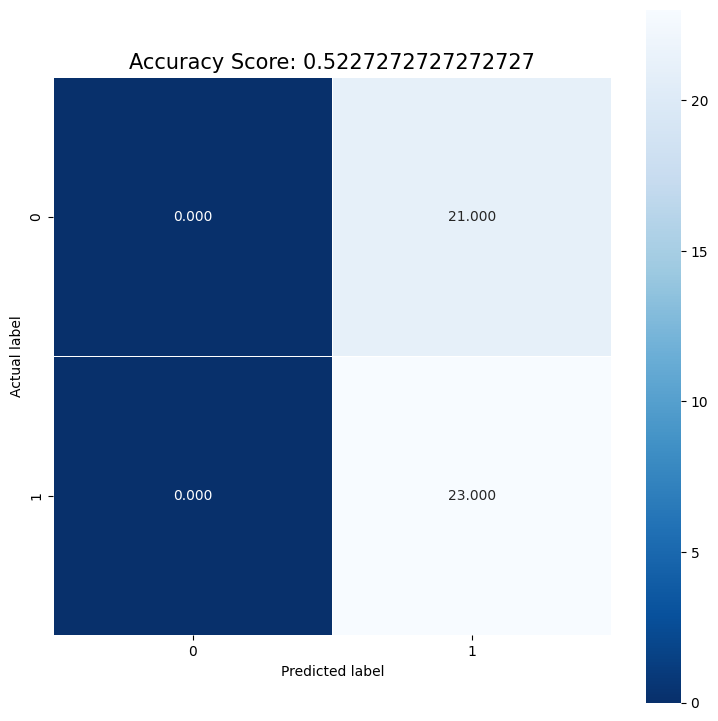

In [32]:
import seaborn as sns
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=0.5, square=True, cmap="Blues_r")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
all_sample_title = "Accuracy Score: {0}".format(score)
plt.title(all_sample_title, size=15);

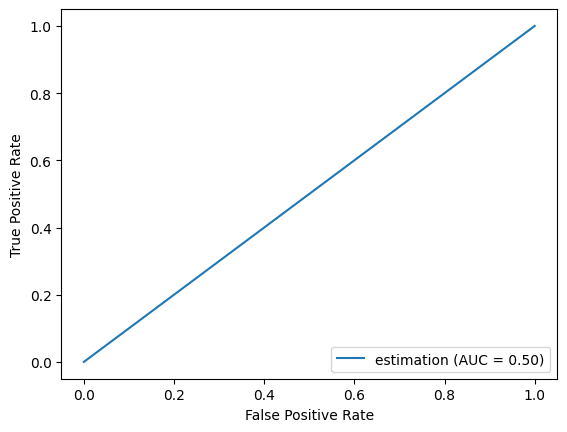

In [33]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="estimation")
display.plot()
plt.show()